In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import torch.nn as nn
from DNN import DeepNet
torch.set_default_dtype(torch.float64)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_device(device) # default tensor device
print("I'm using: ", device)
torch.set_manual(42)


I'm using:  cpu


TypeError: seed() takes 0 positional arguments but 1 was given

## Wave equation


\begin{align*}
  \begin{cases}
    \displaystyle \frac{\partial^2 u}{\partial t^2}-2\frac{\partial^2 u}{\partial x^2}=0, & x\in [0,4], \ \ t\in[0,3],\\[10pt]
    \displaystyle u(x,0)= 0, &x\in[0,4], \\[10pt]
    \displaystyle \frac{\partial u}{\partial t}(x,0) =  \frac{\pi \sqrt2}{2}\sin \Big(\frac{\pi x}{2}\Big), &x\in[0,4], \\[10pt]
    \displaystyle u(0,t)=u(4,t)=0, &t\in[0,3].
  \end{cases}
\end{align*}

In [2]:
def convert(x):
  return x.cpu().detach().numpy()

Define the the FNN with 3 layer, 50 neuron and tanh (https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html#tanh) as activation function

In [3]:
input = 2 
output = 1
hidden_layer = 3*[50]
activation_function = nn.Tanh()

FNN = DeepNet(activation_function,input,hidden_layer,output)
FNN

DeepNet(
  (activation): Tanh()
  (hidden): ModuleList(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1-2): 2 x Linear(in_features=50, out_features=50, bias=True)
  )
  (output): Linear(in_features=50, out_features=1, bias=False)
)

Using torch.random.uniform define the points that will be used for training.

Text(0.5, 1.0, 'Collocation Data')

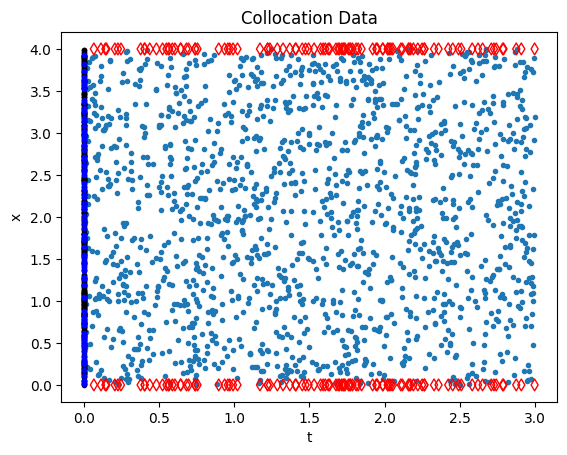

In [4]:
x_ini, x_fin = 0, 4
t_ini, t_fin = 0, 3

N_c = 1500 # number of collocation points
N_0 = 500 # collocation of the initial data
N_0t = 100 #collocation initial data derivate
N_b = 100 # collocation of the boundary coniditon

x_train = np.random.uniform(x_ini,x_fin,(N_c,1))
t_train = np.random.uniform(t_ini,t_fin,(N_c,1))

x_0 = np.random.uniform(x_ini,x_fin,(N_0,1))
t_0 = np.zeros((N_0,1))

x_0_t = np.random.uniform(x_ini,x_fin, (N_0t,1))
t_0_t = np.zeros((N_0t,1))

t_b = np.random.uniform(t_ini,t_fin,(N_b,1))
x_b1 = np.zeros((N_b,1))
x_b2 = np.zeros((N_b,1)) + x_fin
#DATA plot
p1 = plt.figure(1)
plt.scatter(t_train,x_train,marker = '.')
plt.scatter(t_0,x_0,marker = '.', c = 'k')
plt.scatter(t_0_t,x_0_t, marker = '.', c = 'b')
plt.scatter(t_b,x_b1,marker = 'd',facecolors = 'none', edgecolors = 'r')
plt.scatter(t_b,x_b2,marker = 'd',facecolors = 'none', edgecolors = 'r')
plt.xlabel('t')
plt.ylabel('x')
plt.title('Collocation Data')

In [5]:
#reshape of the data
x_train = torch.Tensor(x_train).to(device).requires_grad_(True).view(-1,1)
t_train = torch.Tensor(t_train).to(device).requires_grad_(True).view(-1,1)

x_0 = torch.Tensor(x_0).to(device).requires_grad_(False).view(-1,1)
t_0 = torch.Tensor(t_0).to(device).requires_grad_(False).view(-1,1)

x_0_t = torch.Tensor(x_0_t).to(device).requires_grad_(True).view(-1,1)
t_0_t = torch.Tensor(t_0_t).to(device).requires_grad_(True).view(-1,1)

t_b = torch.Tensor(t_b).to(device).requires_grad_(False).view(-1,1)
x_b1 = torch.Tensor(x_b1).to(device).requires_grad_(False).view(-1,1)
x_b2 = torch.Tensor(x_b2).to(device).requires_grad_(False).view(-1,1)


Test points

In [6]:
N_c_tst = 300
N_0_tst = 1000 #same sample for initial data and initial derivate
N_b_tst = 1000

x_test = torch.linspace(x_ini,x_fin,N_c_tst)
t_test = torch.linspace(t_ini,t_fin,N_c_tst)
x_grid, t_grid = torch.meshgrid(x_test,t_test, indexing = 'ij')
XT = (torch.stack([x_grid.ravel(),t_grid.ravel()],axis = -1 ))

x_0_tst = torch.linspace(x_ini,x_fin, N_0_tst).reshape(1,-1).t()
t_0_tst = torch.zeros_like(x_0_tst)
t_0t_tst = t_0_tst.requires_grad_(True)#needed for the evaluation of the derivate

t_b_tst = torch.linspace(t_ini,t_fin, N_b_tst).reshape(1,-1).t()
x_b1_tst = torch.zeros_like(t_b_tst)
x_b2_tst = torch.zeros_like(t_b_tst) + x_fin

Exact solution and initial condition for the derivative

In [7]:
def u_ex_0_t(x):
  return ( (torch.pi*torch.sqrt(torch.tensor(2.0)))/2 ) * torch.sin((torch.pi*x)/2)

u0_t = convert( u_ex_0_t(x_0_t) )
u0_t_tst =  convert( u_ex_0_t(x_0_tst) )

def u_ex(x,t):
  return torch.sin((torch.pi*x)/2)* torch.sin((torch.pi*torch.sqrt(torch.tensor(2.0))*t)/2)

u = convert( u_ex(x_train,t_train) )
u_tst = convert( u_ex( XT[:,0:1],XT[:,1:2] ) )

Definition of the loss function for the training, where the metric will be define later some examples can be https://pytorch.org/docs/stable/nn.html#loss-functions

In [8]:

def u_theta(x,t): # needed for the evalution of the network on two points
  return FNN(torch.cat([x,t], dim = 1))

def eval_loss_PDE(x,t,metric):
  x.requires_grad_(True)
  t.requires_grad_(True)
  NN = u_theta(x,t)
  u_x = torch.autograd.grad(NN.sum(),x,retain_graph = True, create_graph = True)[0]
  u_xx = torch.autograd.grad(u_x.sum(),x,create_graph = True)[0]
  u_t = torch.autograd.grad(NN.sum(),t,retain_graph = True,create_graph = True)[0]
  u_tt = torch.autograd.grad(u_t.sum(),t,create_graph = True)[0]
  return metric(u_tt, 2*u_xx)

Training of the network, where the optimzer from here https://pytorch.org/docs/stable/optim.html

In [9]:
n_epochs = 2000 
learining_rate = 1e-3
optimizer = torch.optim.Adam(FNN.parameters(),learining_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,50,0.96)

loss_values = np.empty([n_epochs+1,6]); #total,pde,0,0_t,b1,b2
MSE =  torch.nn.MSELoss()
STEP = 100#save every 100 epochs
assert n_epochs%STEP == 0

err_tr = np.empty([int(n_epochs/STEP)+1,5]) #pde,0,0_t,b1,b2
err_tst = np.empty([int(n_epochs/STEP)+1,5])
u_animate = np.empty([int(n_epochs/STEP)+1,XT[:,0:1].size(0)])
k   = 0 

for epoch in range(n_epochs+1):
    
    u_NN     = u_theta(x_train,t_train)
    loss_PDE = eval_loss_PDE(x_train,t_train,MSE)
    #initial
    u_t0    = u_theta(x_0,t_0)
    loss_t0 = u_t0.pow(2).mean()

    #initial derivate
    u_pred_0_t = torch.autograd.grad( u_theta(x_0_t,t_0_t).sum(),t_0_t,create_graph = True)[0]
    loss_0_t =  ( (u_pred_0_t - u_ex_0_t(x_0_t)).pow(2) ).mean()
    
    #1th boundary
    u_pred_b1 = u_theta(x_b1,t_b)
    loss_b1 = u_pred_b1.pow(2).mean()
    #2th boundary
    u_pred_b2 = u_theta(x_b2,t_b)
    loss_b2 = u_pred_b2.pow(2).mean()

    loss = loss_t0 + loss_0_t + loss_PDE + loss_b1 +loss_b2
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()
    
    loss_values[epoch,:] = np.stack([convert(loss), convert(loss_PDE),convert(loss_t0),convert(loss_0_t),convert(loss_b1),convert(loss_b2)])

    if epoch%STEP == 0:
      u_pred_0_tst = torch.autograd.grad( u_theta(x_0_tst,t_0t_tst).sum(),t_0t_tst, create_graph = True )[0]

      u_animate[k,:] = convert(u_theta(XT[:,0:1],XT[:,1:2]).squeeze())
      #with torch.inference_mode():
      err_tr[k,:] = np.stack(
                              [
                              np.linalg.norm( convert(u_theta(x_train,t_train) )  - u  ) / np.linalg.norm(u),
                              np.linalg.norm( convert(u_t0) ),
                              np.linalg.norm( convert(u_pred_0_t) -  u0_t ) / np.linalg.norm(u0_t),
                              np.linalg.norm( convert(u_pred_b1) ),
                              np.linalg.norm( convert(u_pred_b2) ),
                              ]
                              )

      #test error

      err_tst[k,:] = np.stack(
                                    [
                                    np.linalg.norm( convert ( u_theta( XT[:,0:1], XT[:,1:2] ) )  - u_tst ) / np.linalg.norm( u_tst),
                                    np.linalg.norm( convert(u_theta( x_0_tst,t_0_tst ) ) ),
                                    np.linalg.norm( convert( u_pred_0_tst) - u0_t_tst ) / np.linalg.norm( u0_t_tst ) ,
                                    np.linalg.norm( convert(u_theta( x_b1_tst,t_b_tst) ) ),
                                    np.linalg.norm( convert(u_theta( x_b2_tst,t_b_tst ) ) )
                                    ]
                              )



      lr = np.array(scheduler.get_last_lr())

      print(
                  f'Epoch {epoch} | Global Loss {loss_values[epoch,0]:.4e} | Learning rate {lr.squeeze():.4e}' '\n'
                  f'PDE || Loss {loss_values[epoch,1]:.4e} | Training err {err_tr[k,0]:.4e} | Test err {err_tst[k,0]:.4e}''\n'
                  f'Initial condition || Loss {loss_values[epoch,2]:.4e} | Training err {err_tr[k,1]:.4e} | Test err {err_tst[k,1]:.4e}''\n'
                  f'Derivate initial condition || Loss {loss_values[epoch,3]:.4e} | Training err {err_tr[k,2]:.4e} | Test err {err_tst[k,2]:.4e}''\n'
                  f'1th Boundary condition || Loss {loss_values[epoch,4]:.4e} | Training err {err_tr[k,3]:.4e} | Test err {err_tst[k,3]:.4e}''\n'
                  f'2th Boundary condition || Loss {loss_values[epoch,5]:.4e} | Training err {err_tr[k,4]:.4e} | Test err {err_tst[k,4]:.4e}''\n'
                  )
      k+=1

Epoch 0 | Global Loss 1.9026e+01 | Learning rate 1.0000e-03
PDE || Loss 4.0484e-04 | Training err 4.3873e+00 | Test err 4.3196e+00
Initial condition || Loss 5.5640e+00 | Training err 5.2745e+01 | Test err 6.5973e+01
Derivate initial condition || Loss 2.5786e+00 | Training err 1.0007e+00 | Test err 1.0014e+00
1th Boundary condition || Loss 6.2830e+00 | Training err 2.5066e+01 | Test err 7.0971e+01
2th Boundary condition || Loss 4.6001e+00 | Training err 2.1448e+01 | Test err 5.8924e+01

Epoch 100 | Global Loss 2.3774e+00 | Learning rate 9.2160e-04
PDE || Loss 5.6723e-04 | Training err 1.0506e+00 | Test err 1.0551e+00
Initial condition || Loss 5.5128e-03 | Training err 1.6602e+00 | Test err 2.4374e+00
Derivate initial condition || Loss 2.3597e+00 | Training err 9.5726e-01 | Test err 9.5978e-01
1th Boundary condition || Loss 9.6004e-03 | Training err 9.7982e-01 | Test err 3.1919e+00
2th Boundary condition || Loss 1.9272e-03 | Training err 4.3900e-01 | Test err 1.5486e+00

Epoch 200 | Glob

# Visualization of the results
Value of the loss function at the vary of the epochs

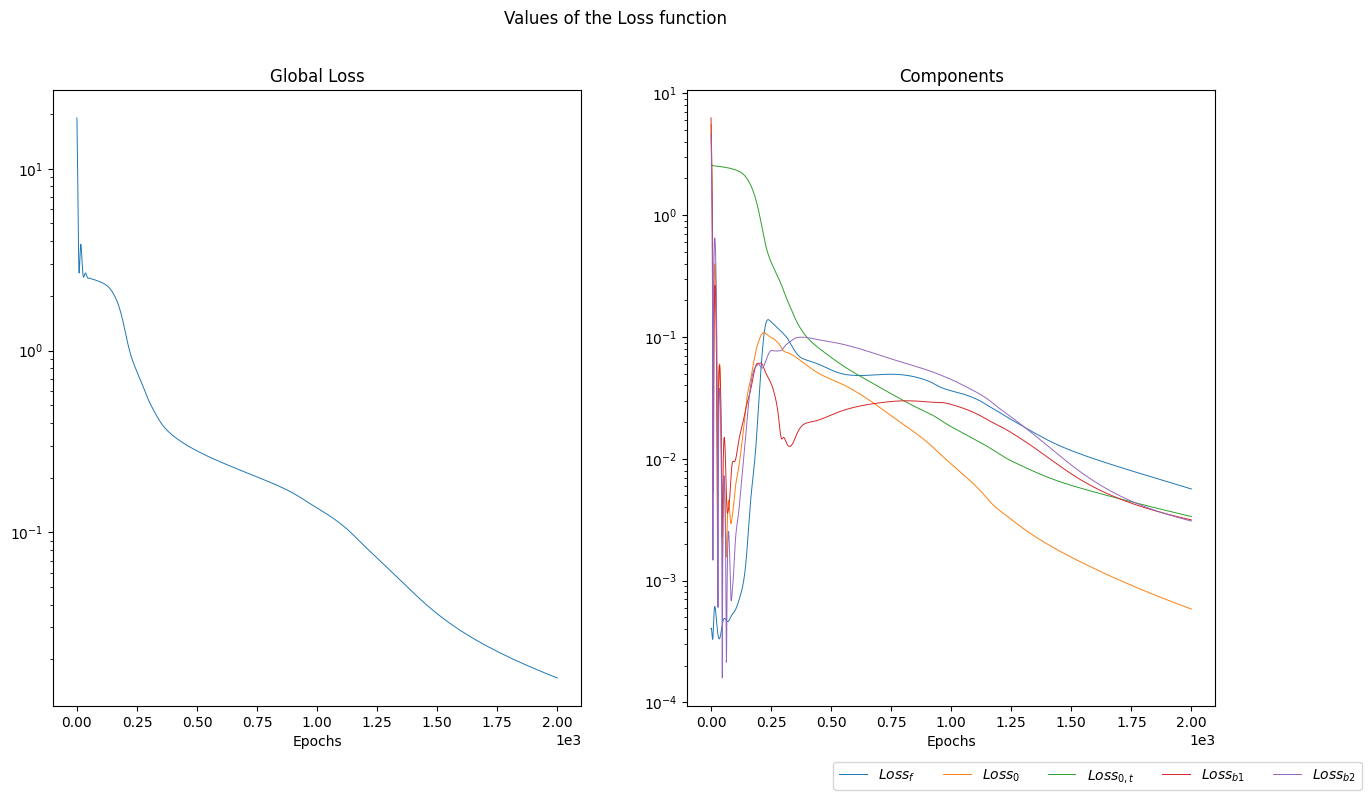

In [10]:
p2 = plt.figure(2, (15,8))

e =  range(n_epochs+1)
ax1, ax2 = p2.subplots(1,2)
ax1.semilogy(e,loss_values[:,0],linewidth=0.7)
ax1.set_title('Global Loss')
ax1.set_xlabel('Epochs')
ax1.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

# plt.ylabel('Loss values')
ax2.semilogy(e,loss_values[:,1],linewidth = 0.7, label = '$Loss_f$')
ax2.semilogy(e,loss_values[:,2],linewidth = 0.7, label = '$Loss_0$')
ax2.semilogy(e,loss_values[:,3],linewidth = 0.7, label = '$Loss_{0,t}$')
ax2.semilogy(e,loss_values[:,4],linewidth = 0.7, label = '$Loss_{b1}$')
ax2.semilogy(e,loss_values[:,5],linewidth = 0.7, label = '$Loss_{b2}$')
ax2.set_xlabel('Epochs')
ax2.set_title('Components')
ax2.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
p2.legend(loc = 'lower right',ncol = 5)

plt.suptitle('Values of the Loss function')
plt.show()

Compare the exact solution with the PINN prediction and evaluate the point-wise error

In [ ]:
with torch.inference_mode():
  # Get the model's prediction
  U_theta = convert( u_theta(XT[:, 0:1], XT[:, 1:2]) )
  # Reshape U_theta to have the same structure as your grid
  U_theta = U_theta.reshape(x_grid.shape)
  u_ex_tst = convert( u_ex(x_grid,t_grid) )
  x_grid = convert(x_grid)
  t_grid = convert(t_grid)

TypeError: sin(): argument 'input' (position 1) must be Tensor, not numpy.ndarray

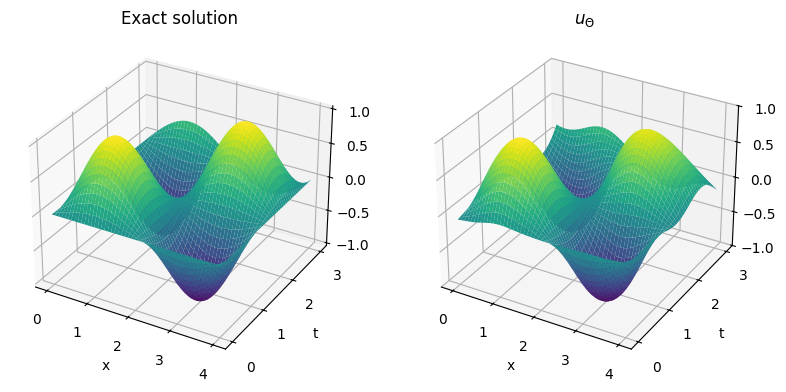

In [12]:
# Plot the surface
p3 = plt.figure(3,figsize=plt.figaspect(0.5))

ax = p3.add_subplot(1,2,1, projection = '3d')
ax.plot_surface(x_grid,t_grid,u_ex_tst, cmap='viridis')
ax.set_title('Exact solution')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.yaxis.set_ticks(np.arange(t_ini,t_fin+1,1))
ax.zaxis.set_ticks(np.arange(-1,1.5,0.5))
ax = p3.add_subplot(1,2,2, projection='3d')
ax.plot_surface(x_grid, t_grid, U_theta, cmap='viridis')
ax.set_title(r'$u_{\Theta}$')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.yaxis.set_ticks(np.arange(t_ini,t_fin+1,1))
ax.zaxis.set_ticks(np.arange(-1,1.5,0.5))
plt.show()

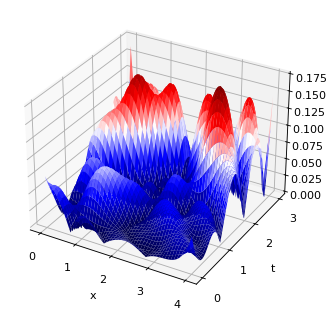

In [13]:
#3D

p4 = plt.figure(4, dpi=80 )
ax = p4.subplots(subplot_kw={'projection': '3d'})
ax.xaxis.set_ticks(np.arange(x_ini, x_fin+1,1))
ax.yaxis.set_ticks(np.arange(t_ini,t_fin+1,1))
ax.plot_surface(x_grid,t_grid, np.abs(U_theta - u_ex_tst ) , cmap = 'seismic')
ax.set_xlabel('x')
ax.set_ylabel('t')

ax.ticklabel_format(style='sci', axis='z', useMathText=True, scilimits=(-5,6))


In [14]:
#2D
p5 = plt.figure(5, dpi = 80 )

plt.contourf(x_grid.numpy(), t_grid.numpy(), np.abs(U_theta - u_ex_tst) , cmap='seismic')
plt.xticks(np.arange(x_ini, x_fin+1,1))
plt.yticks(np.arange(t_ini,t_fin+1,1))
plt.xlabel('x')
plt.ylabel('t')
plt.colorbar(format='%.0e')

AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

<Figure size 512x384 with 0 Axes>

$L^2$ Errors

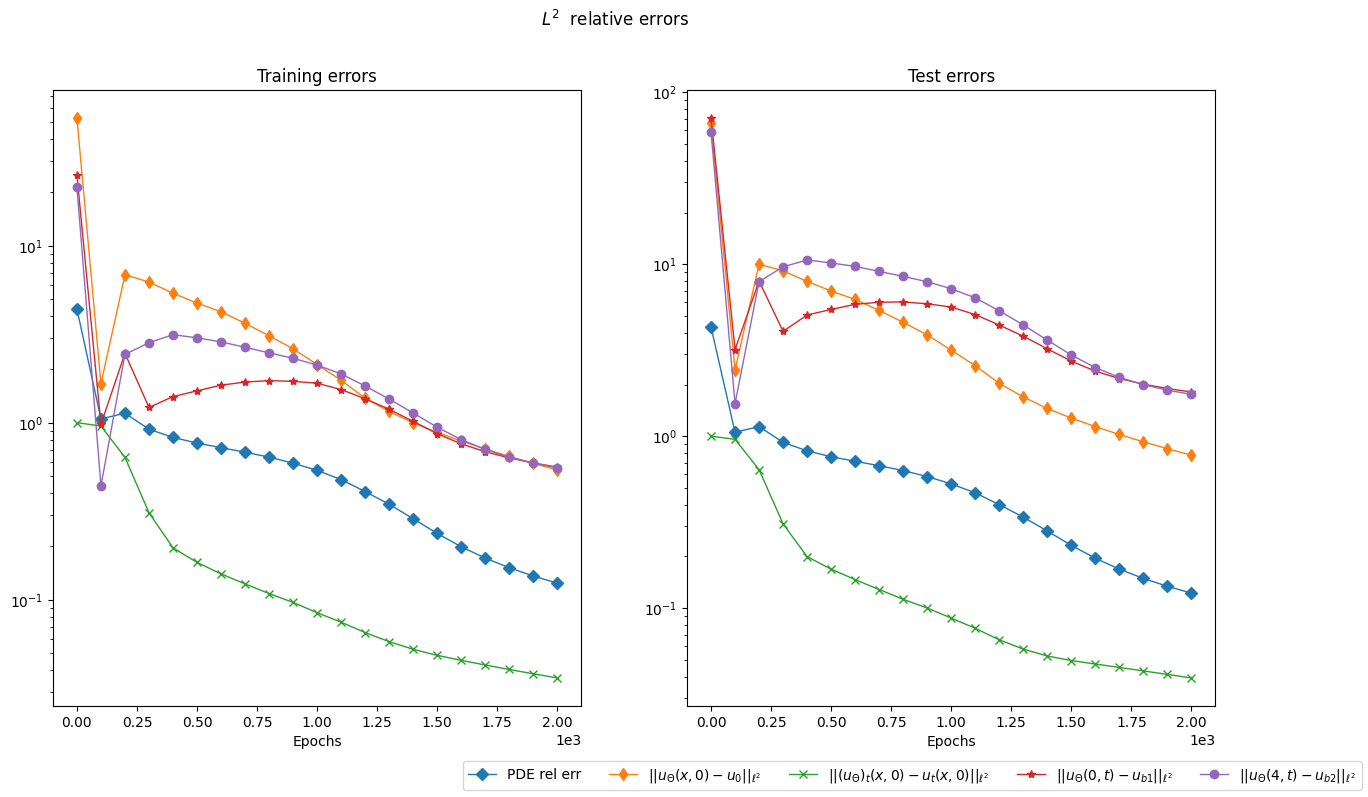

In [17]:
p6 = plt.figure(6,figsize=(15,8))
p6.suptitle('$L^2$  relative errors')
ax1,ax2 = p6.subplots(1,2)
E = np.arange(0,n_epochs+1,STEP)
ax1.semilogy(E,err_tr[:,0], marker = 'D', linewidth = 1, label = 'PDE rel err')
ax1.semilogy(E,err_tr[:,1], marker = 'd', linewidth = 1, label = r'$||u_{\Theta}(x,0) - u_0||_{\ell^2}$' )
ax1.semilogy(E,err_tr[:,2],marker = 'x', linewidth = 1, label = r'$||(u_{\Theta})_t(x,0) - u_t(x,0)||_{\ell^2}$')
ax1.semilogy(E,err_tr[:,3],marker = '*', linewidth = 1, label = r'$||u_{\Theta}(0,t)-u_{b1}||_{\ell^2}$')
ax1.semilogy(E,err_tr[:,4],marker = 'o', linewidth = 1, label = r'$||u_{\Theta}(4,t)-u_{b2}||_{\ell^2}$')
ax1.set_xlabel('Epochs')
ax1.set_title('Training errors')
ax1.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

ax2.semilogy(E,err_tst[:,0],marker = 'D', linewidth = 1)
ax2.semilogy(E,err_tst[:,1],marker = 'd', linewidth = 1)
ax2.semilogy(E,err_tst[:,2],marker = 'x', linewidth = 1)
ax2.semilogy(E,err_tst[:,3],marker = '*', linewidth = 1)
ax2.semilogy(E,err_tst[:,4],marker = 'o', linewidth = 1)
ax2.set_xlabel('Epochs')
ax2.set_title('Test errors')
p6.legend(loc = 'lower right', ncol = 5)
ax2.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.show()

Animation of the solution during training 

In [ ]:
%matplotlib widget
fig,(axs1,axs2)  = plt.subplots(1,2,figsize = (10,8),subplot_kw={'projection': '3d'})

axs1.plot_surface(x_grid,t_grid,u_ex_tst, cmap='viridis')
axs1.set_title('Exact solution')
axs1.set_xlabel('x')
axs1.set_ylabel('t')
axs1.set_xticks(np.arange(0,x_fin+1,1))
axs1.set_yticks(np.arange(0,t_fin+1,1))
axs1.zaxis.set_ticks(np.arange(-1,1.5,0.5))

def updata_data(frame):
    U_animate = u_animate[frame,:].reshape(x_grid.shape)
    axs2.clear()
    axs2.plot_surface(x_grid,t_grid,U_animate,cmap = 'viridis')
    axs2.set_xlabel('x')
    axs2.set_ylabel('t')
    axs2.set_title(r'$u_{\Theta}$')
    axs2.grid('on')
    axs2.zlim([-1,1])
    plt.suptitle(f'Epoch {frame*STEP}')
    return axs2

animation = FuncAnimation(fig,func = updata_data,frames=len(u_animate),interval = 5)
plt.show()
#for google colab
#from IPython.display import HTML
#video = HTML(anim.to_html5_video())
#display(video)
#plt.close()